In [1]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
import tensorflow.contrib.eager as tfe
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from functools import partial
import shogun as sg

D:\Anaconda3\envs\TensorFlowGpu\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


In [2]:
plt.rcParams['font.size'] = 14

In [3]:
%matplotlib inline

In [4]:
tf.enable_eager_execution()

# Model Classes

## cINN

In [5]:
class ConditionalInvertibleBlock(tf.keras.Model):
    
    """Implements a conditional version of the INN block."""
    def __init__(self, meta, alpha=1.9):
        """
        Creates a conditional invertible block with its own call() method.

        Arguments:
        meta  : list         -- a list of dictionary, where each dictionary holds parameter - value pairs for a single 
                       keras.Dense layer
        alpha : float or None -- used to do soft clamping ot the outputs (loss smoothing)
        """
        super(ConditionalInvertibleBlock, self).__init__()
        
        self.alpha = alpha
        self.s1 = tf.keras.Sequential([tf.keras.layers.Dense(**params) for params in meta])
        self.s2 = tf.keras.Sequential([tf.keras.layers.Dense(**params) for params in meta])
        self.t1 = tf.keras.Sequential([tf.keras.layers.Dense(**params) for params in meta])
        self.t2 = tf.keras.Sequential([tf.keras.layers.Dense(**params) for params in meta])
        
    def call(self, x, y, inverse=False, log_det_jacobian=True):
        """Implements both directions of a conditional invertible block."""
        
        # --- Forward pass --- #
        if not inverse:
            u1, u2 = tf.split(x, 2, axis=1)

            # Precompute network outputs for v1
            s1 = self.s1(tf.concat((u2, y), axis=1))
            # Clamp s1 if specfiied
            if self.alpha is not None:
                s1 = (2. * self.alpha / np.pi) *  tf.math.atan(s1 / self.alpha)
            t1 = self.t1(tf.concat((u2, y), axis=1))
            v1 = u1 * tf.exp(s1) + t1

            # Precompute network outputs for v2
            s2 = self.s2(tf.concat((v1, y), axis=1))
            # Clamp s2 if specified
            if self.alpha is not None:
                s2 = (2. * self.alpha / np.pi) *  tf.math.atan(s2 / self.alpha)
            t2 = self.t2(tf.concat((v1, y), axis=1))
            v2 = u2 * tf.exp(s2) + t2
            v = tf.concat((v1, v2), axis=1)
            if log_det_jacobian:
                # log|J| = log(prod(diag(J))) -> according to inv architecture
                return v, tf.reduce_sum(s1 + s2, axis=1)
            return v

        # --- Inverse pass --- #
        else:
            v1, v2 = tf.split(x, 2, axis=1)
            
            # Compute s2
            s2 = self.s2(tf.concat((v1, y), axis=1))
            # Clamp s2 if specified
            if self.alpha is not None:
                s2 = (2. * self.alpha / np.pi) *  tf.math.atan(s2 / self.alpha)
            u2 = (v2 - self.t2(tf.concat((v1, y), axis=1))) * tf.exp(-s2)
            
            # Compute s1
            s1 = self.s1(tf.concat((u2, y), axis=1))
            # Clamp s1 if specified
            if self.alpha is not None:
                s1 = (2. * self.alpha / np.pi) *  tf.math.atan(s1 / self.alpha)
            u1 = (v1 - self.t1(tf.concat((u2, y), axis=1))) * tf.exp(-s1)
            
            u = tf.concat((u1, u2), axis=1)
            return u

        
class SummaryNetwork(tf.keras.Model):
    """A model to preprocess the conditional input via 1x1 convolution."""
    
    def __init__(self, n_hidden=512):
        """Creates a GRU summayr network to learn summary statistics."""
        super(SummaryNetwork, self).__init__()
        
        self.gru = tf.keras.layers.CuDNNGRU(n_hidden)
    
    def call(self, x):
        return self.gru(x)

    
class DeepConditionalModel(tf.keras.Model):
    def __init__(self, x_dim, summary_hidden, invertible_meta):
        """
        Creates a summary network and a chain of cINN blocks.
        
        Arguments:
        x_dim           : int  -- the dimensionality of the space to be learned
        summary_hidden  : int  -- the dimensionality of the GRU summayr network
        invertible_meta : list -- a list of dictionary, where each dictionary holds parameter - value pairs for a single 
                                  keras.Dense layer
        """

        super(DeepConditionalModel, self).__init__()
        
        self.summary_network = SummaryNetwork(summary_hidden)
        self.cINNs = [ConditionalInvertibleBlock(meta) for meta in invertible_meta]
        self.x_dim = x_dim
        
    def call(self, x, y, inverse=False):
        
        y = self.summary_network(y)
        if inverse:
            return self.inverse(x, y)
        else:
            return self.forward(x, y)
            
    def forward(self, x, y):
        
        z = x
        log_det_Js = []
        for cINN in self.cINNs:
            z, log_det_J = cINN(z, y)
            log_det_Js.append(log_det_J)
        # Sum jacobian determinants
        log_det_J = tf.add_n(log_det_Js)
        return z, log_det_J
    
    def inverse(self, x, y):
        for cINN in reversed(self.cINNs):
            x = cINN(x, y, inverse=True)
        return x
    
    def sample(self, n_samples, y):
        """Samples from the inverse model given y."""
        
        # Pass y through summary network
        # y becomes a tf.Tensor of shape (1, summary_dim)
        y = self.summary_network(y)

        # Draw n_samples from standard normal
        z_normal_samples = tf.random_normal(shape=(n_samples, self.x_dim), dtype=tf.float32)
        
        # Sample batch by repeating y over the batch dimension
        X_samples = self.inverse(z_normal_samples, tf.tile(y, [n_samples, 1]))
    
        return X_samples

## Bayesian linear regression class

<p>In this example, we train a cINN to approximate the posterior distribution of the regression weights of a Bayesian linear regression model.</p>
<hr>
<p><strong>Setting:</strong></p>
<p>Assume we have observed $n$ pairs of data points:</p>
$$D = \{(\mathbf{x}_{i}, y_{i})\}_{i=1,...,n}$$
<p>where</p>
$$\mathbf{x} \in \mathbb{R}^d, y \in \mathbb{R}$$
<p><strong>Model:</strong></p>
<p>We model each $y_{i}$ as being drawn from a Gaussian distribution paramaterized by:</p>
$$y_{i} \sim \mathcal{N}(\mathbf{\beta}^T\mathbf{x}, a^{-1})$$
<p>where $a$ is the precision, (i.e., inverse variance), so $a = \dfrac{1}{\sigma_{y}^2}$</p>
<p>We place the followng prior on the regression weights:</p>
$$\beta \sim \mathcal{N}_{d}(\mathbf{0}, b^{-1}\mathbf{I}_{d})$$
<p>where $\mathcal{N}_{d}(., .)$ denotes a $d$-dimensional Gaussian distribtuion</p> and $b$ is the precision of the distribution, i.e. $b = \dfrac{1}{\sigma_{\beta}^2}$.
<p>When $a$ and $b$ are known, the likelihood $p(D|\mathbf{\beta})$ is proportional to:</p>
$$p(D|\mathbf{\beta}) \propto \exp(-\dfrac{a}{2}(y - \mathbf{X}\mathbf{\beta})^T(y - \mathbf{X}\mathbf{\beta}))$$
<p>and the posterior of $\mathbf{\beta}$ is proportional to:</p>
$$p(\mathbf{\beta}|D) \propto \exp(-\dfrac{a}{2}(y - \mathbf{X}\mathbf{\beta})^T(y - \mathbf{X}\mathbf{\beta}) - \dfrac{b}{2}\mathbf{\beta}^T\mathbf{\beta})$$
<p>where $X$ is the design matrix in which each row $i$ represents $\mathbf{x}_{i}^T$. Since the prior is conjugate to the likelihood, the posterior is also Gaussian with the following form:</p>
$$p(\mathbf{\beta}|D) = \mathcal{N}_{d}(\mathbf{\beta}|\mathbf{\mu}, \mathbf{\Lambda}^{-1})$$
<p>where $\mathbf{\Lambda}$ is the precision matrix (inverse covariance matrix) and the posterior mean and covariance are calculated as follows:</p>
<br>
$$\mathbf{\Lambda} = a\mathbf{X}^T\mathbf{X} + b\mathbf{I}_{d}$$
$$\mathbf{\mu} = a\mathbf{\Lambda}^{-1}\mathbf{X}^T\mathbf{y}$$
<p>The preceding calculation are implemented in the class <em>BayesianLinearRegression</em> defined below.</p>

In [6]:
class BayesianLinearRegression:
    
    def __init__(self, x_dim, b=1., a=1.):
        self.x_dim = x_dim
        self.b = b # Precision of p(w|b) ~ N(0, b^-1I)
        self.a = a # Precision of p(y | beta.Tx, a^-1)
        self.Ix = np.identity(self.x_dim)
        self.prior_beta = stats.multivariate_normal(np.zeros(self.x_dim), (1/self.b) * self.Ix)
        
    def _generate_design_mat(self, n_samples):
        return np.random.randn(n_samples, self.x_dim)
    
    def _sample_beta(self):
        """Prior on beta is a normal N(0, b^-1I)."""
        return self.prior_beta.rvs()
    
    def generate_data(self, n_samples):
        """Generates a single regression dataset."""
        
        X = self._generate_design_mat(n_samples)
        beta = self._sample_beta()
        y = X @ beta + np.random.normal(0., np.sqrt((1/self.a)), n_samples)
        return beta, np.c_[X, y]
    
    def generate_multiple_datasets(self, n_datasets, to_tensor=True, n=None):
        """Generates multiple regression datasets by calling generate_data() multiple times."""
        
        # Draw n from U(50, 500), if n not fixed
        if n is None:
            n = np.random.randint(50, 501)
        
        X = np.zeros((n_datasets, n, self.x_dim+1))
        betas = np.zeros((n_datasets, self.x_dim))
        
        for i in range(n_datasets):
            beta, D = self.generate_data(n)
            X[i] = D
            betas[i] = beta
        if to_tensor:
            return tf.convert_to_tensor(betas, dtype=tf.float32), tf.convert_to_tensor(X, dtype=tf.float32)
        return betas, X
    
    def posterior_beta(self, D, n_samples=None):
        """Computes the posterior of beta given data as described above."""
        
        # Extract X and y
        X = D[:, :self.x_dim]
        y = D[:, self.x_dim]
        
        # Compute mean and cov of Gaussian posterior
        cov = np.linalg.inv(self.a * X.T @ X + self.b * self.Ix)
        mu = self.a * cov @ X.T @ y
        
        if n_samples is None:
            return stats.multivariate_normal(mu, cov)
        return stats.multivariate_normal(mu, cov).rvs(n_samples)

# Functions

## Utility Functions

In [7]:
def maximum_likelihood_loss(z, log_det_J):
    """
    Computes the ML loss as described by Ardizzone et al. (in press).
    
    Arguments:
    z : tf.Tensor of shape (BATCH_SIZE, Z_DIM) -- the output of the final CC block f(x; c, W)
    J : tf.Tensor of shape (BATCH_SIZE, )      -- the log determinant of the jacobian computed the CC block.
    
    Output:
    loss : scalar -- Monte-Carlo approximation of E[ ||z||^2 / 2 - log|det(J)| ]
    """
    
    return tf.reduce_mean(0.5 * tf.square(tf.norm(z, axis=1)) - log_det_J)


def apply_gradients(optimizer, gradients, variables, global_step=None):
    """Performs one step of backpropagation."""
    
    optimizer.apply_gradients(zip(gradients, variables), global_step=global_step)
    
    
def train_loop(epochs, model, optimizer, data_generator, 
               batch_size, verbose_each, clip_value=None, n=None, global_step=None):
    """
    Helper function to perform #epochs training steps. In each step,
    new data is generated through the gen_fun wrapper.
    """
    
    losses = {
        'ml_loss': [],
        'decay': []
    }
    for ep in range(1, epochs+1):
        with tf.GradientTape() as tape:
            
            # Generate data
            X, Y = data_generator.generate_multiple_datasets(batch_size, to_tensor=True,n=n)
            
            # Forward pass
            Z, log_det_J = model(X, Y)
            
            # Compute total_loss = ML Loss + Regularization loss
            ml_loss = maximum_likelihood_loss(Z, log_det_J)
            decay = tf.add_n(model.losses)
            total_loss = ml_loss + decay
            
            # Store losses
            losses['ml_loss'].append(ml_loss.numpy())
            losses['decay'].append(decay.numpy())
            
            # One step backprop
            gradients = tape.gradient(total_loss, model.trainable_variables)
            if clip_value is not None:
                gradients, _ = tf.clip_by_global_norm(gradients, clip_value)
            apply_gradients(optimizer, gradients, model.trainable_variables, global_step)  
            
        if ep % verbose_each == 0:
            print('Epoch:', ep, 
                  'ML Loss:', ml_loss.numpy(),
                  'Running ML Loss: ', np.mean(losses['ml_loss'][-verbose_each:]),
                  'Regularization Loss:', decay.numpy())
    return losses


def plot_true_est_posterior(model, reg, n_samples, X_test, Y_test, params_names, 
                            figsize=(15, 20), filename=None):
    """Plots X_test.shape[0] rows of posterior samples vs true means."""
    
    # Initialize figure
    n_sim = X_test.numpy().shape[0]
    f, axarr = plt.subplots(n_sim, len(params_names), figsize=figsize)
    
    # For each row 
    for i in range(n_sim):
        
        # Sample from approximate posterior given current Y
        if model is not None:
            X_samples = model.sample(n_samples, Y_test[i:i+1]).numpy()
            X_samples_means = X_samples.mean(axis=0)
        
        # Sample from true posterior given current Y
        X_analytic_samples = reg.posterior_beta(Y_test[i].numpy(), n_samples=n_samples)
        X_analytic_means = X_analytic_samples.mean(axis=0)
        
        # Extracttrue data generating values
        X_true = X_test.numpy()[i]
        
        for j in range(len(params_names)):
            
            # Plot KDE of approximate posterior, of model specified
            if model is not None:
                sns.distplot(X_samples[:, j], kde=True, hist=True, ax=axarr[i, j], 
                             label='Estimated', color='#5c92e8')
            # Plot KDE of analytic posterior
            sns.distplot(X_analytic_samples[:, j], kde=True, hist=True, ax=axarr[i, j], 
                         label='Analytic', color='#e55e5e')
            
            # Plot lines for approximate mean, analytic mean and true data-generating value
            if model is not None:
                axarr[i, j].axvline(X_samples_means[j], color='#5c92e8')
            axarr[i, j].axvline(X_analytic_means[j], color='#e55e5e')
            axarr[i, j].axvline(X_true[j], color='black', label='True')
            axarr[i, j].spines['right'].set_visible(False)
            axarr[i, j].spines['top'].set_visible(False)
            
            # Set title of first row
            if i == 0:
                axarr[i, j].set_title(params_names[j])
            
            if i == 0 and j == 0:
                axarr[i, j].legend(fontsize=10)
            
    f.tight_layout()
    
    # Save if specified
    if filename is not None:
        f.savefig("figures/{}_{}n_density.png".format(filename, Y_test.shape[1]), dpi=600)
    
    
def plot_true_est_scatter(model, reg, n_samples, X_test, Y_test, params_names, figsize=(20, 4), filename=None):
    """Plots a scatter plot with abline of the estimated posterior means vs true values."""
    
    # Initialize figure
    f, axarr = plt.subplots(1, len(params_names), figsize=figsize)

    
    # Initialize posterior means matrix
    X_samples_means = np.zeros((X_test.shape[0], len(params_names)))
    
    # --- Sample parameter from approx posterior and calculate means and vars --- #
    for i in range(X_test.shape[0]):
        X_samples = model.sample(n_samples, Y_test[i:i+1]).numpy()
        X_samples_means[i, :] = X_samples.mean(axis=0)
        
    # --- Compute analytic posterior and extract mean--- #
    X_true_means = np.zeros((X_test.shape[0], len(params_names)))
    for i in range(X_test.shape[0]): 
        post = reg.posterior_beta(Y_test[i].numpy())
        X_true_means[i, :] = post.mean

    # --- Plot true vs estimated posterior means on a single row --- #
    for j in range(len(params_names)):
        
        # Plot analytic vs estimated
        axarr[j].scatter(X_samples_means[:, j], X_true_means[:, j], color='black', alpha=0.4)
        
        # get axis limits and set equal x and y limits
        lower_lim = min(axarr[j].get_xlim()[0], axarr[j].get_ylim()[0])
        upper_lim = max(axarr[j].get_xlim()[1], axarr[j].get_ylim()[1])
        axarr[j].set_xlim((lower_lim, upper_lim))
        axarr[j].set_ylim((lower_lim, upper_lim))
        axarr[j].plot(axarr[j].get_xlim(), axarr[j].get_xlim(), '--', color='black')
        
        # Compute NRMSD
        rmsd = np.sqrt(np.mean( (X_samples_means[:, j] - X_true_means[:, j])**2 ))
        nrmsd = rmsd / (X_true_means[:, j].max() - X_true_means[:, j].min())
        axarr[j].text(0.2, 0.9, 'NRMSD={:.3f}'.format(nrmsd),
                     horizontalalignment='center',
                     verticalalignment='center',
                     transform=axarr[j].transAxes)
        
        # Compute R2
        r2 = r2_score(X_true_means[:, j], X_samples_means[:, j])
        axarr[j].text(0.2, 0.8, '$R^2$={:.3f}'.format(r2),
                     horizontalalignment='center',
                     verticalalignment='center',
                     transform=axarr[j].transAxes)
        
        if j == 0:
            # Label plot
            axarr[j].set_xlabel('Estimated Mean')
            axarr[j].set_ylabel('Analytic Mean')
        axarr[j].set_title(params_names[j])
        axarr[j].spines['right'].set_visible(False)
        axarr[j].spines['top'].set_visible(False)
    
    # Adjust spaces
    f.tight_layout()
    
    # Save if specified
    if filename is not None:
        f.savefig("figures/{}_{}n_scatter.png".format(filename, Y_test.shape[1]), dpi=600)
    
    
def plot_losses(losses):
    """Plots ML loss and decay."""
    f, axarr = plt.subplots(1, 2, figsize=(15, 5))
    axarr[0].plot(losses['ml_loss'])
    axarr[1].plot(losses['decay'])
    axarr[0].set_title('ML Loss')
    axarr[1].set_title('Decay')
    

def compute_mmd(p, q):
    """
    Based on: 
    http://shogun-toolbox.org/notebook/latest/mmd_two_sample_testing.html
    """
    
    features_p = sg.RealFeatures(p.reshape(1, p.shape[0]).astype(np.float64))
    features_q = sg.RealFeatures(q.reshape(1, q.shape[0]).astype(np.float64))

    # choose kernel for testing. Here: Gaussian
    kernel_width=1
    kernel = sg.GaussianKernel(10, kernel_width)

    # create mmd instance of test-statistic
    mmd = sg.QuadraticTimeMMD()
    mmd.set_kernel(kernel)
    mmd.set_p(features_p)
    mmd.set_q(features_q)

    # compute biased and unbiased test statistic (default is unbiased)

    mmd.set_statistic_type(sg.ST_UNBIASED_FULL)
    unbiased_statistic = mmd.compute_statistic()
    p_value = mmd.compute_p_value(unbiased_statistic)
    
    return unbiased_statistic, p_value

def kl_mv_gaussian(mu_p, sigma_p, mu_q, sigma_q):
    """
    Computes the KL divergence between two random MVNs.
    Args:
    mu_p    - vector of shape (n_dim, 1)
    sigma_p - SPD matrix of shape (n_dim, n_dim)
    mu_q    - vector of shape (n_dim, 1)
    sigma_q - SPD matrix of shape (n_dim, n_dim)
    """
    
    
    d = sigma_p.shape[0]
    log_det_sigma_q_p = np.log(np.linalg.det(sigma_q) / np.linalg.det(sigma_p))
    tr_sigma_q_p = np.trace(np.linalg.inv(sigma_q) @ sigma_p)
    mah_dist = (mu_q - mu_p) @ np.linalg.inv(sigma_q) @ (mu_q - mu_p)
    kl = 0.5 * (log_det_sigma_q_p + tr_sigma_q_p + mah_dist - d)
    return kl

def mmd_batch(model, reg, n_samples, X_test, Y_test):
    """Computes MMD and p-values on a batch of samples."""
    
    
    n = X_test.numpy().shape[0]
    d = X_test.numpy().shape[1]
    
    mmds_ps = np.zeros((n * d, 2))
    
    # For each row 
    for i in range(n):
          
        # Sample n_samples from approximate and analytic
        X_samples = model.sample(n_samples, Y_test[i:i+1]).numpy()
        X_analytic_samples = reg.posterior_beta(Y_test[i].numpy(), n_samples)
        
        # Compute mmd for each beta
        for j in range(d):
            mmd, p = compute_mmd(X_samples[:, j], X_analytic_samples[:, j])
            mmds_ps[i * d + j] = np.array([mmd, p])
    return mmds_ps    


def mmd_plot(model, reg, n_samples, X_test2, Y_test2, figsize=(15, 10)):
    """Plots and saves the MMDs for given Ns."""
    
    # Compute MMDs
    mmd_p = mmd_batch(model, reg, n_samples, X_test2, Y_test2)
    
    # Plot MMDs
    f, ax = plt.subplots(1, 1, figsize=figsize)
    sns.distplot(mmd_p[:, 0], kde=False, hist=True, rug=True, label='uMMD', ax=ax)
    ax.axvline(np.mean(mmd_p[:, 0]), color='black', label='Mean MMD')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('Unbiased MMD')
    ax.set_ylabel('Frequency')
    ax.set_xlim([0.0, 2.0])
    ax.legend()
    f.savefig('figures/mmd_plot_{}.png'.format(Y_test2.shape[1]), dpi=600)
    return mmd_p

## Test functions

In [8]:
def test_cINN_block_forward_inverse(meta):
    """Tests if g(f(x, w), w) == x."""
    
    cINN = ConditionalInvertibleBlock(meta)
    x, y = tf.random_normal(shape=(1, 4)), tf.random_normal(shape=(1, 4))
    o, _ = cINN(x, y)
    x_hat = cINN(o, y, inverse=True)
    return np.allclose(x.numpy(), x_hat.numpy())

# Train on Bayesian Linear Regression

## Training and Simulation Hyperparameters

In [9]:
# --- Training hyperparameters --- #
x_dim = 4
global_step = tfe.Variable(0, dtype=tf.int32)
n_samples_test_desnity = 10
n_samples_test_means = 300
batch_size = 64
iterations = 40000
w_decay = 0.00001
summary_hidden = 512
verbose_each = 100
starter_learning_rate = 0.001
decay_steps = 5000
decay_rate = .85
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, decay_steps, decay_rate)


# --- Invertible chain hyperparameters --- #
invertible_meta = [
[   
    {'units': 128, 
     'activation': 'elu', 
     'kernel_initializer': 'glorot_uniform',
     'kernel_regularizer': l2(w_decay)},
    {'units': 128, 
     'activation': 'elu', 
     'kernel_initializer': 'glorot_uniform',
     'kernel_regularizer': l2(w_decay)},
    {'units': x_dim//2, 
     'kernel_initializer': 'glorot_uniform',
     'kernel_regularizer': l2(w_decay)}
],
[   
    {'units': 128, 
     'activation': 'elu', 
     'kernel_initializer': 'glorot_uniform',
     'kernel_regularizer': l2(w_decay)},
    {'units': 128, 
     'activation': 'elu', 
     'kernel_initializer': 'glorot_uniform',
     'kernel_regularizer': l2(w_decay)},
    {'units': x_dim//2, 
     'kernel_initializer': 'glorot_uniform',
     'kernel_regularizer': l2(w_decay)}
],
[   
    {'units': 128, 
     'activation': 'elu', 
     'kernel_initializer': 'glorot_uniform',
     'kernel_regularizer': l2(w_decay)},
    {'units': 128, 
     'activation': 'elu', 
     'kernel_initializer': 'glorot_uniform',
     'kernel_regularizer': l2(w_decay)},
    {'units': x_dim//2, 
     'kernel_initializer': 'glorot_uniform',
     'kernel_regularizer': l2(w_decay)}
],
[   
    {'units': 128, 
     'activation': 'elu', 
     'kernel_initializer': 'glorot_uniform',
     'kernel_regularizer': l2(w_decay)},
    {'units': 128, 
     'activation': 'elu', 
     'kernel_initializer': 'glorot_uniform',
     'kernel_regularizer': l2(w_decay)},
    {'units': x_dim//2, 
     'kernel_initializer': 'glorot_uniform',
     'kernel_regularizer': l2(w_decay)}
],
[   
    {'units': 128, 
     'activation': 'elu', 
     'kernel_initializer': 'glorot_uniform',
     'kernel_regularizer': l2(w_decay)},
    {'units': 128, 
     'activation': 'elu', 
     'kernel_initializer': 'glorot_uniform',
     'kernel_regularizer': l2(w_decay)},
    {'units': x_dim//2, 
     'kernel_initializer': 'glorot_uniform',
     'kernel_regularizer': l2(w_decay)}
],
[   
    {'units': 128, 
     'activation': 'elu', 
     'kernel_initializer': 'glorot_uniform',
     'kernel_regularizer': l2(w_decay)},
    {'units': 128, 
     'activation': 'elu', 
     'kernel_initializer': 'glorot_uniform',
     'kernel_regularizer': l2(w_decay)},
    {'units': x_dim//2, 
     'kernel_initializer': 'glorot_uniform',
     'kernel_regularizer': l2(w_decay)}
],
]


# ----- Data generation function----- #
params_names = [r'$\beta_{1}$', r'$\beta_{2}$', r'$\beta_{3}$', r'$\beta_{4}$']
b_reg = BayesianLinearRegression(x_dim)


# ------ Tests ------ #
assert test_cINN_block_forward_inverse(invertible_meta[0])

## Model and Optimizer

In [10]:
# Model and optimizer
model = DeepConditionalModel(x_dim, summary_hidden, invertible_meta)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

## Test Data

In [10]:
X_test, Y_test = b_reg.generate_multiple_datasets(n_samples_test_desnity, to_tensor=True)

In [11]:
X_test2, Y_test2 = b_reg.generate_multiple_datasets(n_samples_test_means, to_tensor=True)

## Test untrained model

Instructions for updating:
Colocations handled automatically by placer.


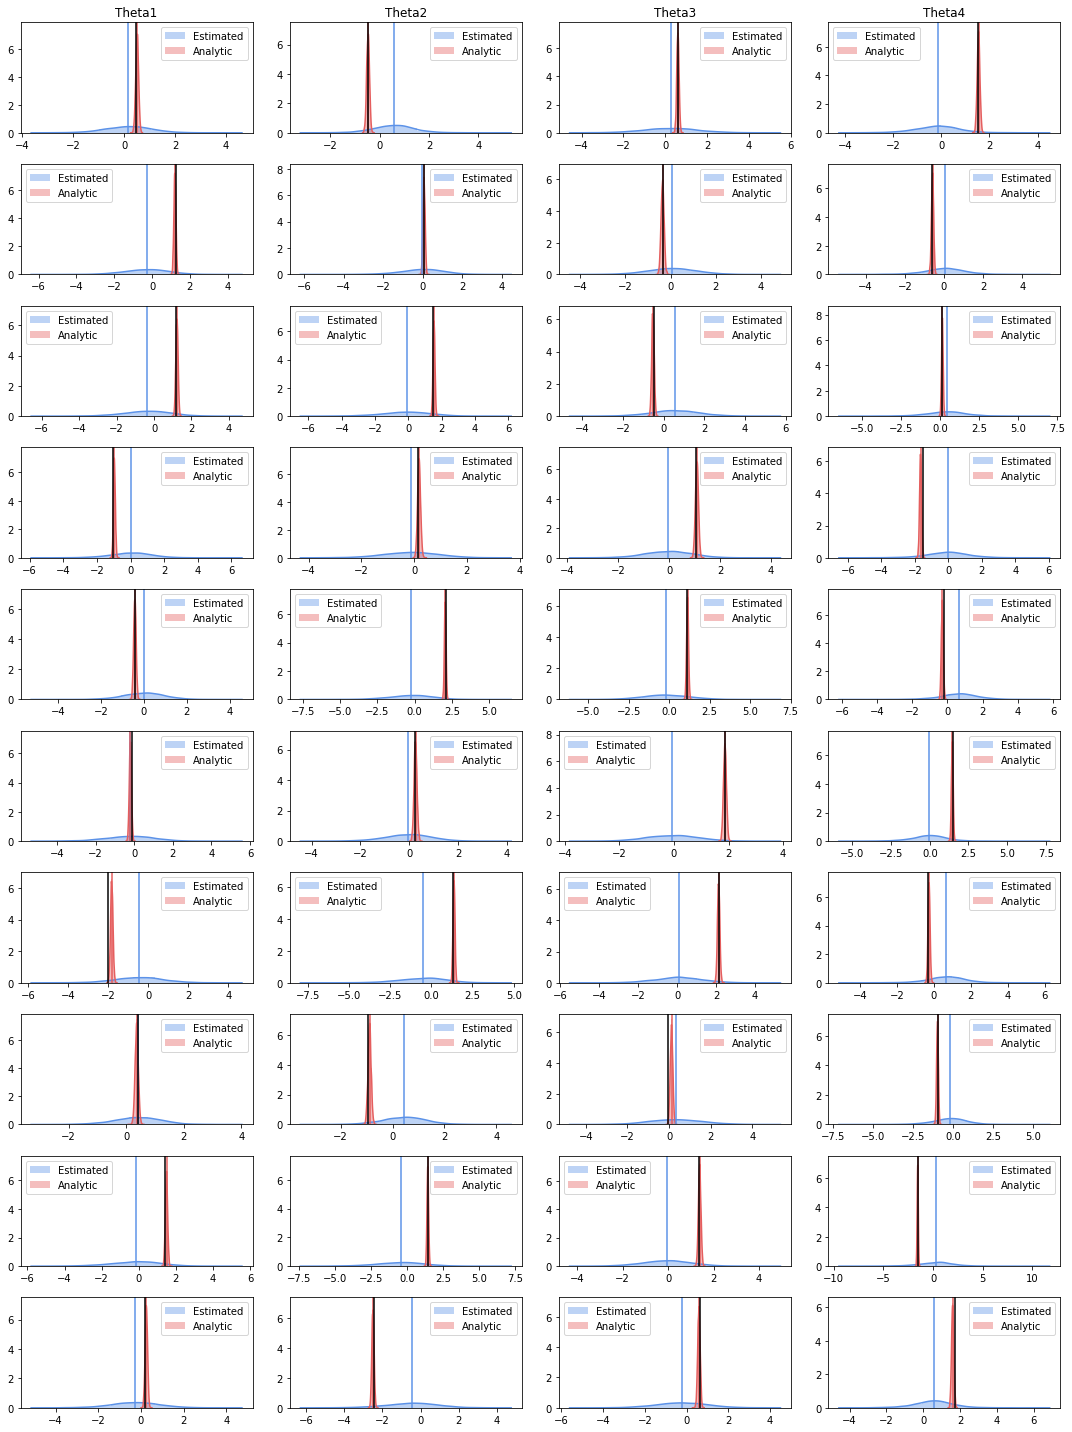

In [12]:
%%time
plot_true_est_posterior(model, b_reg, 5000, X_test, Y_test, params_names)

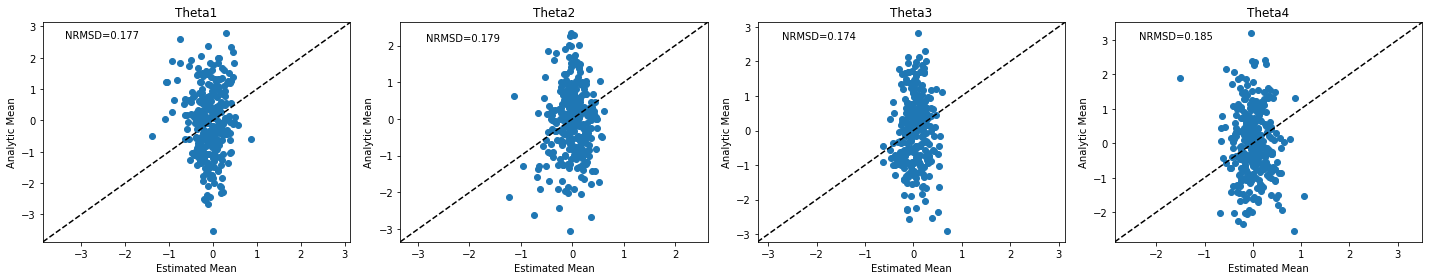

In [13]:
%%time
plot_true_est_scatter(model, b_reg, 5000, X_test2, Y_test2, params_names)

## 40000 iterations
<p> The model thus sees batch_size * iterations data points. </p>

In [14]:
%%time
losses = train_loop(iterations, model, optimizer, b_reg, batch_size, verbose_each, global_step=global_step)

Epoch: 100 ML Loss: 1.2652876 Running ML Loss:  3.2907133 Regularization Loss: 0.081043884
Epoch: 200 ML Loss: -0.6135912 Running ML Loss:  -0.014148717 Regularization Loss: 0.08085564
Epoch: 300 ML Loss: -1.0531312 Running ML Loss:  -1.0188771 Regularization Loss: 0.0806764
Epoch: 400 ML Loss: -2.0083 Running ML Loss:  -1.3018196 Regularization Loss: 0.08048436
Epoch: 500 ML Loss: -1.9941318 Running ML Loss:  -1.6137886 Regularization Loss: 0.08029307
Epoch: 600 ML Loss: -2.6089902 Running ML Loss:  -2.3168426 Regularization Loss: 0.08011391
Epoch: 700 ML Loss: -3.0247328 Running ML Loss:  -2.6774015 Regularization Loss: 0.07991305
Epoch: 800 ML Loss: -3.5888348 Running ML Loss:  -2.9275296 Regularization Loss: 0.079729915
Epoch: 900 ML Loss: -3.1577187 Running ML Loss:  -3.2787442 Regularization Loss: 0.079541124
Epoch: 1000 ML Loss: -4.3184934 Running ML Loss:  -4.2066536 Regularization Loss: 0.079366565
Epoch: 1100 ML Loss: -5.6170096 Running ML Loss:  -5.0386567 Regularization Los

Epoch: 9000 ML Loss: -5.7813115 Running ML Loss:  -8.311944 Regularization Loss: 0.04539547
Epoch: 9100 ML Loss: -8.067942 Running ML Loss:  -8.142433 Regularization Loss: 0.04479409
Epoch: 9200 ML Loss: -7.431464 Running ML Loss:  -8.102586 Regularization Loss: 0.044207945
Epoch: 9300 ML Loss: -7.1115484 Running ML Loss:  -8.106375 Regularization Loss: 0.04359234
Epoch: 9400 ML Loss: -8.418343 Running ML Loss:  -8.105329 Regularization Loss: 0.042995553
Epoch: 9500 ML Loss: -8.148428 Running ML Loss:  -8.264684 Regularization Loss: 0.04238177
Epoch: 9600 ML Loss: -8.881521 Running ML Loss:  -8.194288 Regularization Loss: 0.041759882
Epoch: 9700 ML Loss: -9.425282 Running ML Loss:  -8.414692 Regularization Loss: 0.041193638
Epoch: 9800 ML Loss: -8.793203 Running ML Loss:  -8.284355 Regularization Loss: 0.040586386
Epoch: 9900 ML Loss: -8.466072 Running ML Loss:  -8.281607 Regularization Loss: 0.040008605
Epoch: 10000 ML Loss: -9.38146 Running ML Loss:  -8.247727 Regularization Loss: 0.

Epoch: 17900 ML Loss: -9.687704 Running ML Loss:  -8.424084 Regularization Loss: 0.016513497
Epoch: 18000 ML Loss: -9.4744835 Running ML Loss:  -8.550287 Regularization Loss: 0.016419258
Epoch: 18100 ML Loss: -7.693193 Running ML Loss:  -8.280266 Regularization Loss: 0.016533965
Epoch: 18200 ML Loss: -9.037024 Running ML Loss:  -8.308249 Regularization Loss: 0.01638043
Epoch: 18300 ML Loss: -8.88785 Running ML Loss:  -8.5587225 Regularization Loss: 0.016242977
Epoch: 18400 ML Loss: -5.3646536 Running ML Loss:  -8.441087 Regularization Loss: 0.01609875
Epoch: 18500 ML Loss: -8.293608 Running ML Loss:  -8.480587 Regularization Loss: 0.015962414
Epoch: 18600 ML Loss: -7.3191223 Running ML Loss:  -8.346615 Regularization Loss: 0.015834399
Epoch: 18700 ML Loss: -9.480013 Running ML Loss:  -8.315599 Regularization Loss: 0.015721967
Epoch: 18800 ML Loss: -6.8094163 Running ML Loss:  -8.219163 Regularization Loss: 0.015663665
Epoch: 18900 ML Loss: -8.313492 Running ML Loss:  -8.500189 Regulari

Epoch: 26800 ML Loss: -6.353619 Running ML Loss:  -8.427319 Regularization Loss: 0.012097941
Epoch: 26900 ML Loss: -8.496811 Running ML Loss:  -8.590991 Regularization Loss: 0.012066072
Epoch: 27000 ML Loss: -9.760329 Running ML Loss:  -8.535212 Regularization Loss: 0.012027763
Epoch: 27100 ML Loss: -8.063444 Running ML Loss:  -8.579594 Regularization Loss: 0.011965181
Epoch: 27200 ML Loss: -8.3846245 Running ML Loss:  -8.504306 Regularization Loss: 0.011925201
Epoch: 27300 ML Loss: -6.3272285 Running ML Loss:  -8.583678 Regularization Loss: 0.0118820565
Epoch: 27400 ML Loss: -9.8270645 Running ML Loss:  -8.539258 Regularization Loss: 0.011871502
Epoch: 27500 ML Loss: -9.384962 Running ML Loss:  -8.671322 Regularization Loss: 0.01185319
Epoch: 27600 ML Loss: -8.7129345 Running ML Loss:  -8.666569 Regularization Loss: 0.0118912235
Epoch: 27700 ML Loss: -9.179048 Running ML Loss:  -8.567157 Regularization Loss: 0.011921099
Epoch: 27800 ML Loss: -9.803034 Running ML Loss:  -8.458589 Regul

Epoch: 35600 ML Loss: -7.478627 Running ML Loss:  -8.729379 Regularization Loss: 0.010613839
Epoch: 35700 ML Loss: -9.208911 Running ML Loss:  -8.581941 Regularization Loss: 0.010608367
Epoch: 35800 ML Loss: -5.520438 Running ML Loss:  -8.618591 Regularization Loss: 0.010593196
Epoch: 35900 ML Loss: -9.55147 Running ML Loss:  -8.632701 Regularization Loss: 0.010546321
Epoch: 36000 ML Loss: -9.518751 Running ML Loss:  -8.6408 Regularization Loss: 0.010539241
Epoch: 36100 ML Loss: -7.1913667 Running ML Loss:  -8.557998 Regularization Loss: 0.010529114
Epoch: 36200 ML Loss: -8.245626 Running ML Loss:  -8.621237 Regularization Loss: 0.010520464
Epoch: 36300 ML Loss: -9.708641 Running ML Loss:  -8.404995 Regularization Loss: 0.010563336
Epoch: 36400 ML Loss: -6.9488044 Running ML Loss:  -8.684004 Regularization Loss: 0.010551415
Epoch: 36500 ML Loss: -9.001856 Running ML Loss:  -8.777658 Regularization Loss: 0.010554992
Epoch: 36600 ML Loss: -9.254398 Running ML Loss:  -8.765415 Regularizat

### Save model

In [ ]:
model.save_weights('models/bayesian_regression_rnn_40k_final_decay')

### Plot approximate posteriors vs analytic posteriors

#### N = 50

In [54]:
X_test, Y_test = b_reg.generate_multiple_datasets(n_samples_test_desnity, to_tensor=True, n=50)
X_test2, Y_test2 = b_reg.generate_multiple_datasets(n_samples_test_means, to_tensor=True, n=50)

Wall time: 13.6 s


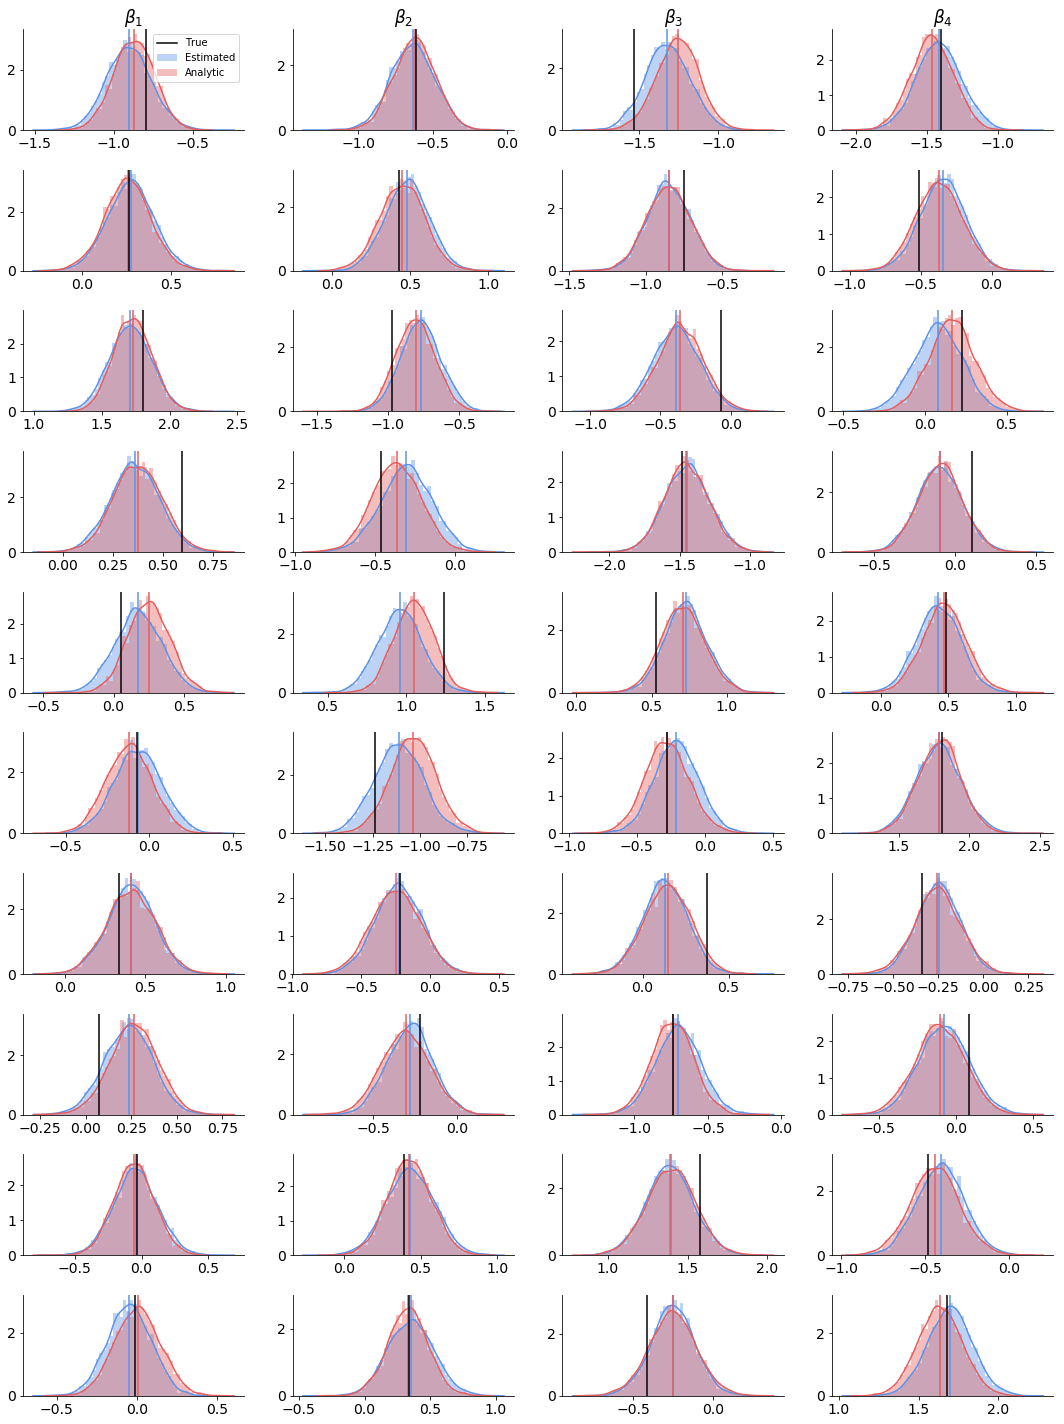

In [55]:
%%time
plot_true_est_posterior(model, b_reg, 5000, X_test, Y_test, params_names)

Wall time: 11.7 s


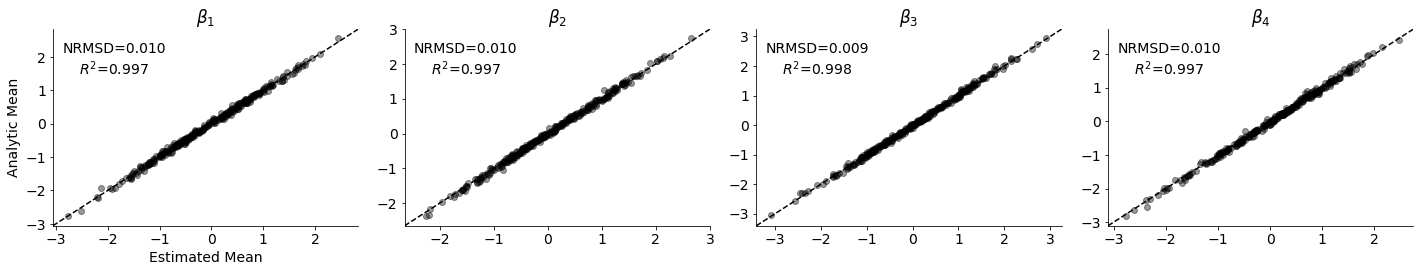

In [56]:
%%time
plot_true_est_scatter(model, b_reg, 5000, X_test2, Y_test2, params_names)

#### N = 100

In [57]:
X_test, Y_test = b_reg.generate_multiple_datasets(n_samples_test_desnity, to_tensor=True, n=100)
X_test2, Y_test2 = b_reg.generate_multiple_datasets(n_samples_test_means, to_tensor=True, n=100)

Wall time: 5.88 s


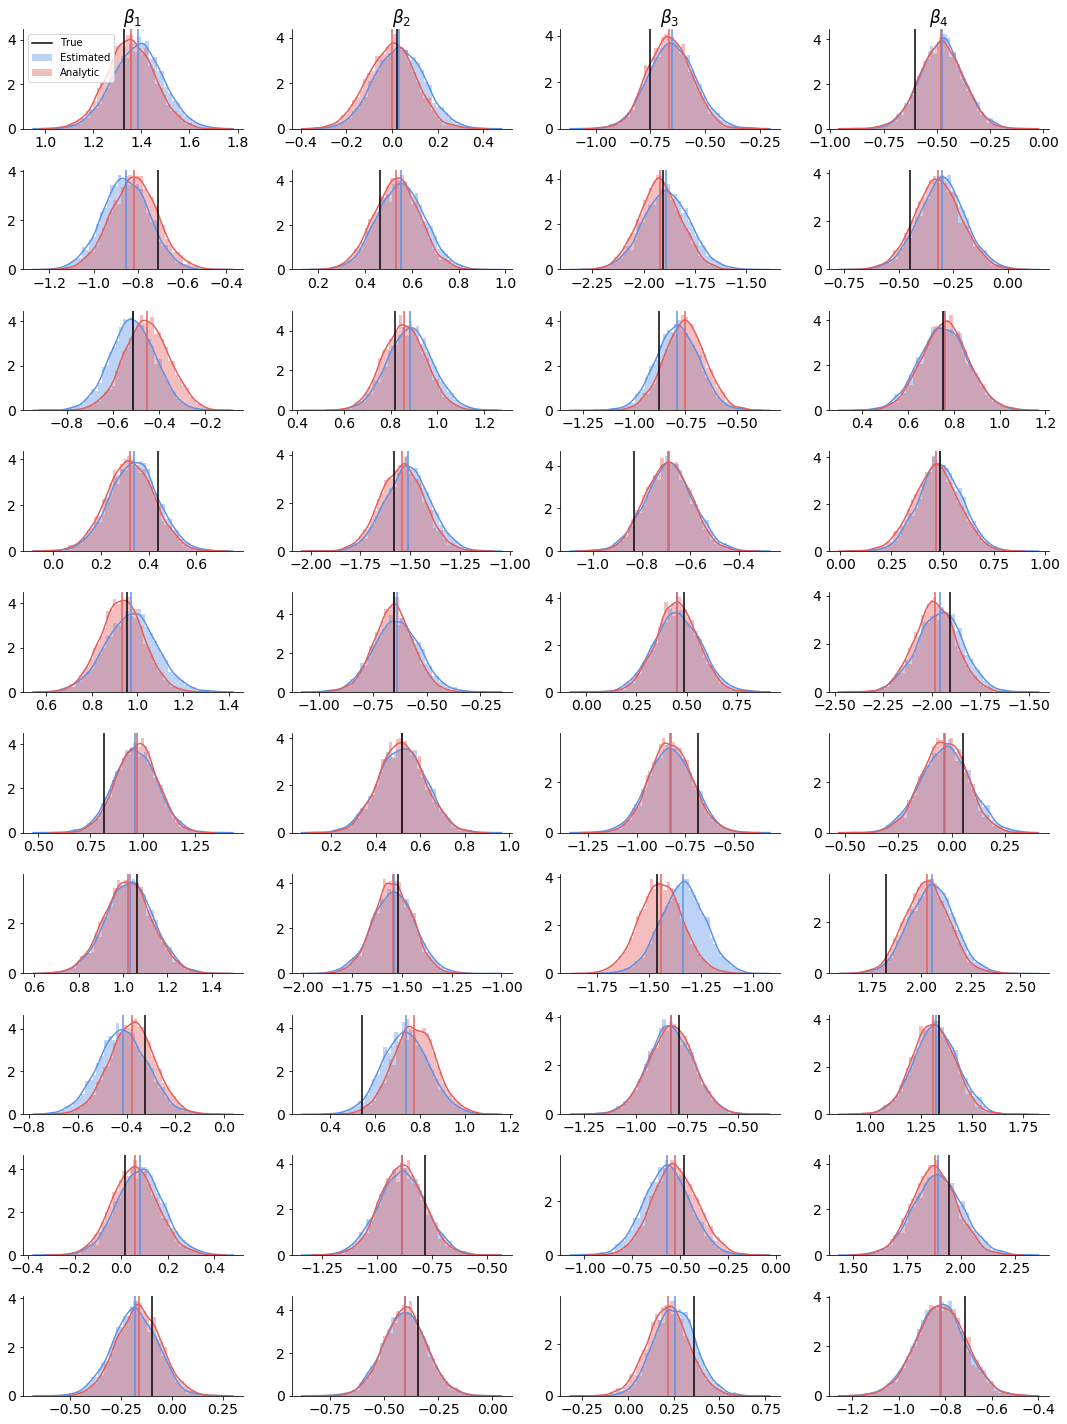

In [58]:
%%time
plot_true_est_posterior(model, b_reg, 5000, X_test, Y_test, params_names)

Wall time: 12.5 s


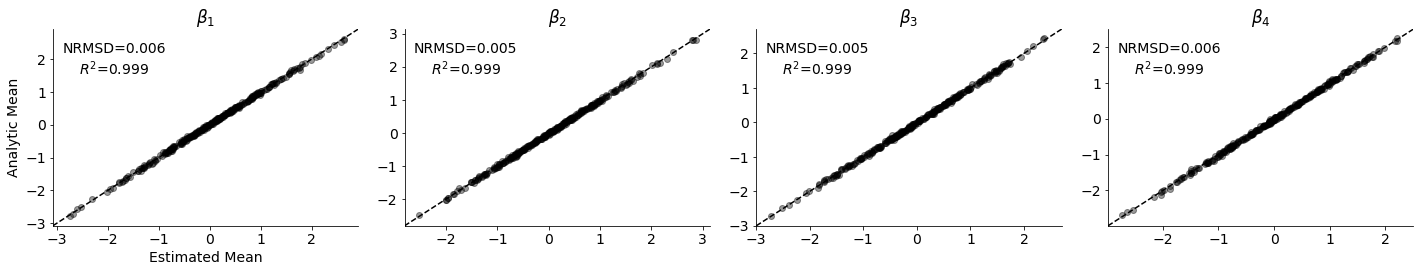

In [59]:
%%time
plot_true_est_scatter(model, b_reg, 5000, X_test2, Y_test2, params_names)

#### N = 250

In [60]:
X_test, Y_test = b_reg.generate_multiple_datasets(n_samples_test_desnity, to_tensor=True, n=250)
X_test2, Y_test2 = b_reg.generate_multiple_datasets(n_samples_test_means, to_tensor=True, n=250)

Wall time: 7.77 s


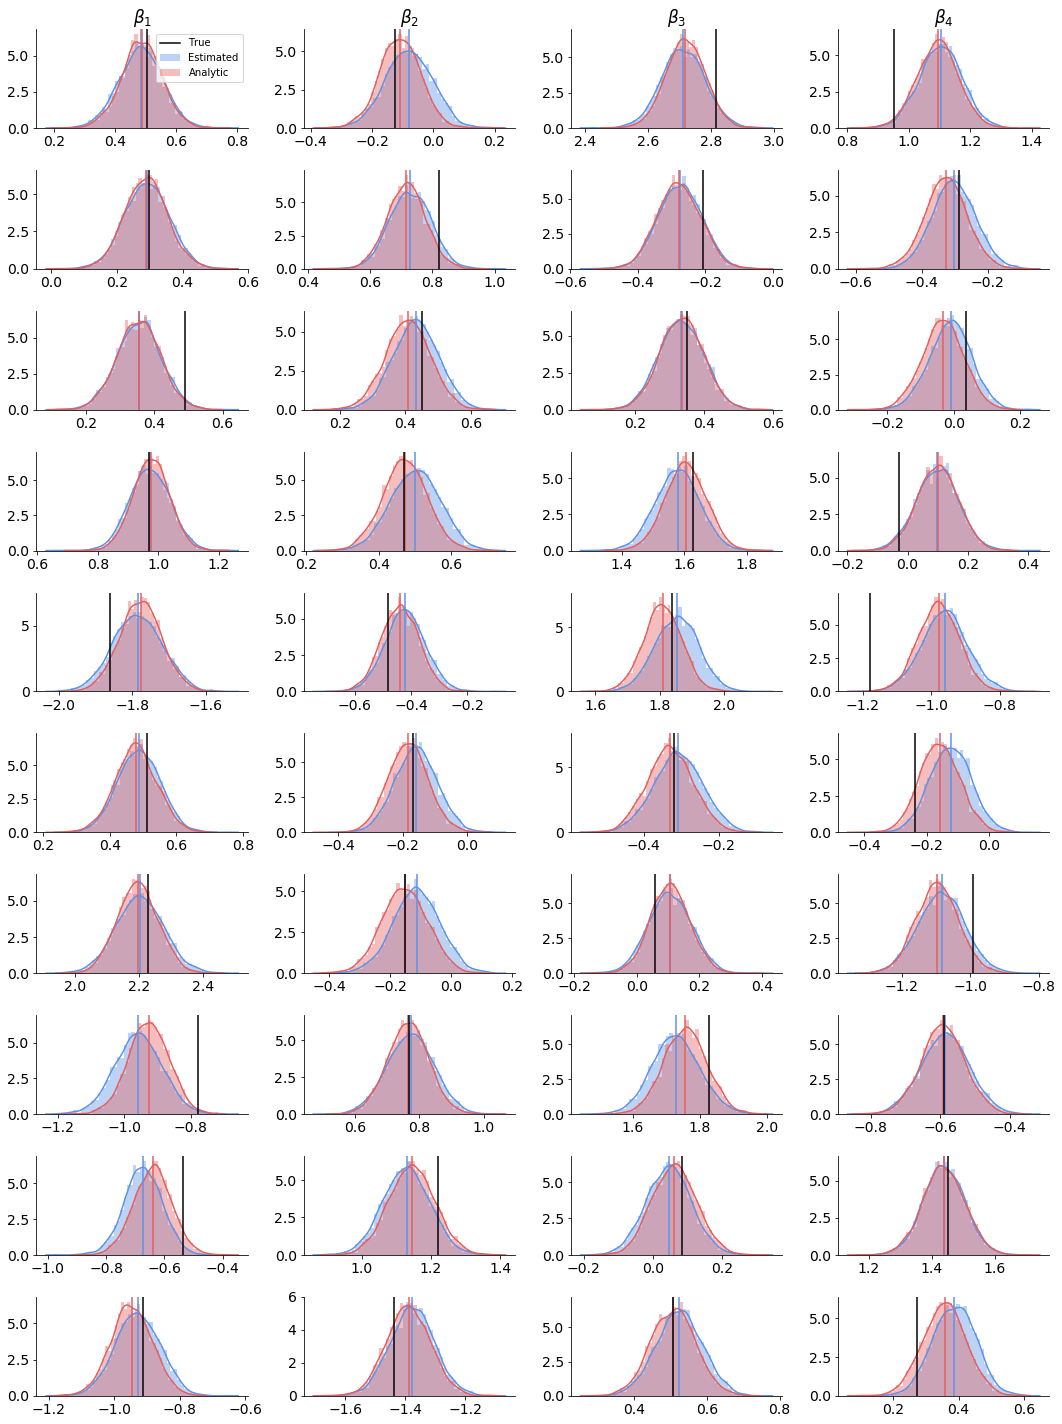

In [61]:
%%time
plot_true_est_posterior(model, b_reg, 5000, X_test, Y_test, params_names)

Wall time: 14.3 s


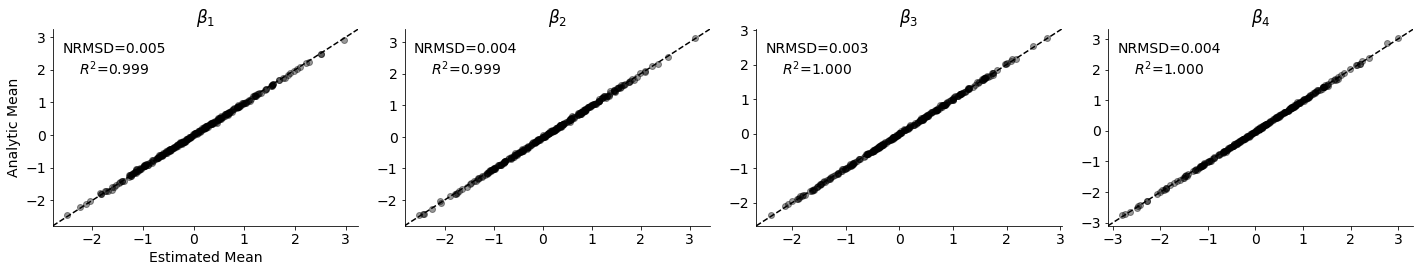

In [62]:
%%time
plot_true_est_scatter(model, b_reg, 5000, X_test2, Y_test2, params_names)

#### N = 500

In [63]:
X_test, Y_test = b_reg.generate_multiple_datasets(n_samples_test_desnity, to_tensor=True, n=500)
X_test2, Y_test2 = b_reg.generate_multiple_datasets(n_samples_test_means, to_tensor=True, n=500)

Wall time: 5.43 s


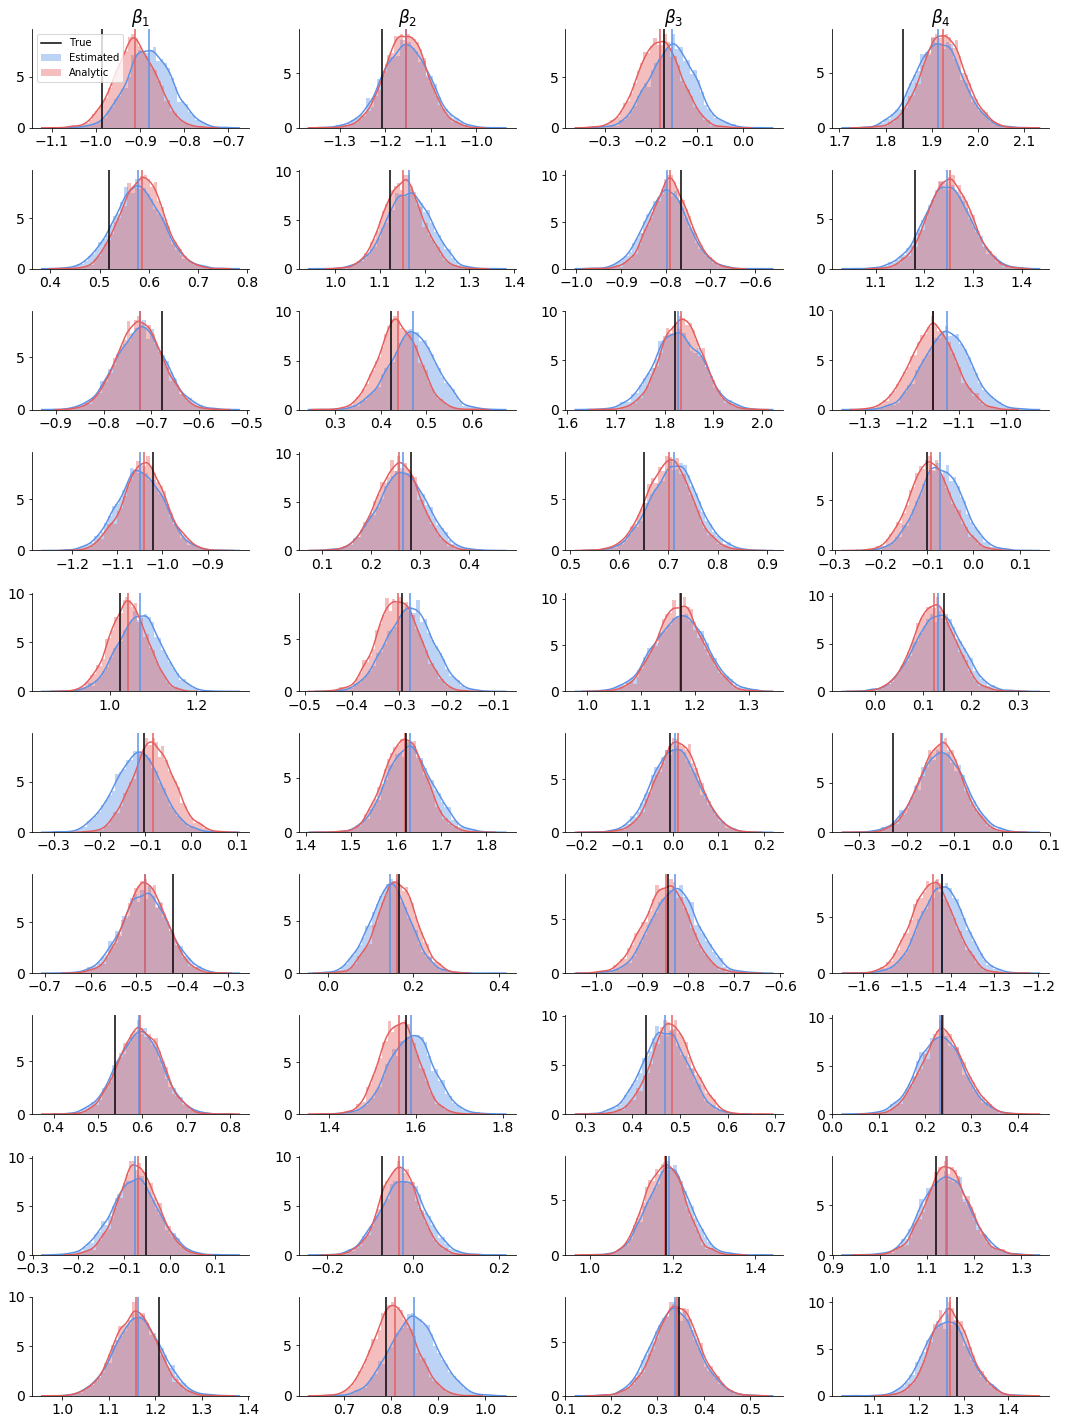

In [64]:
%%time
plot_true_est_posterior(model, b_reg, 5000, X_test, Y_test, params_names)

Wall time: 16.7 s


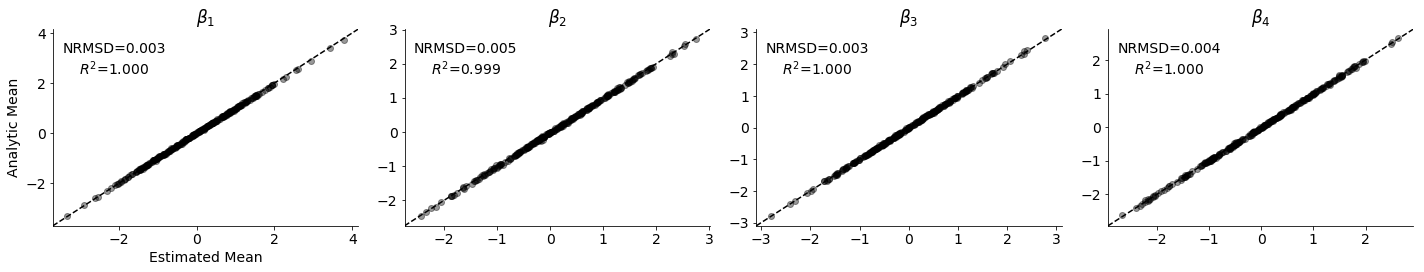

In [65]:
%%time
plot_true_est_scatter(model, b_reg, 5000, X_test2, Y_test2, params_names)

## Load model

In [11]:
model.load_weights('models/bayesian_regression_rnn_40k_final_decay')

## Plots for paper

In [14]:
X_test, Y_test = b_reg.generate_multiple_datasets(3, to_tensor=True, n=100)
X_test2, Y_test2 = b_reg.generate_multiple_datasets(n_samples_test_means, to_tensor=True, n=100)

Wall time: 3.62 s


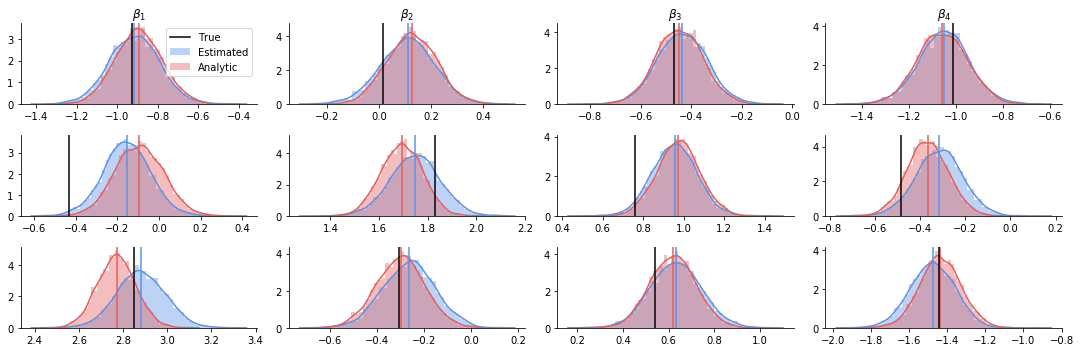

In [15]:
%%time
plot_true_est_posterior(model, b_reg, 5000, X_test, Y_test, params_names, figsize=(15, 5), filename='regression')

Wall time: 15 s


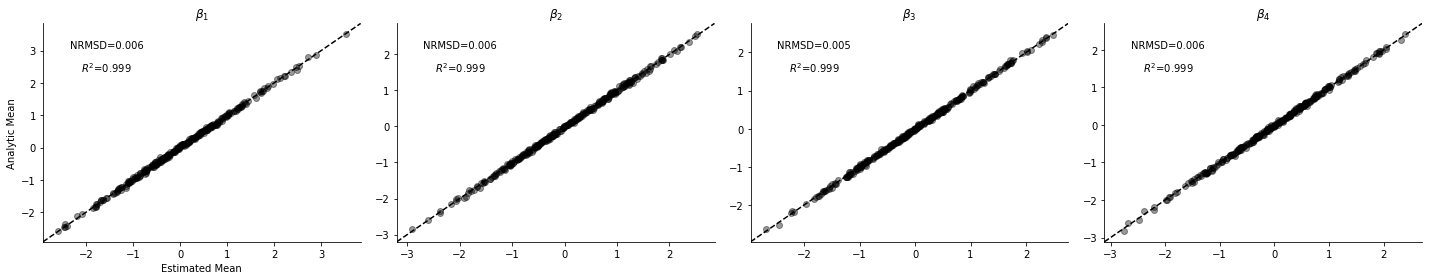

In [16]:
%%time
plot_true_est_scatter(model, b_reg, 5000, X_test2, Y_test2, params_names, filename='regression')

Wall time: 8min 46s


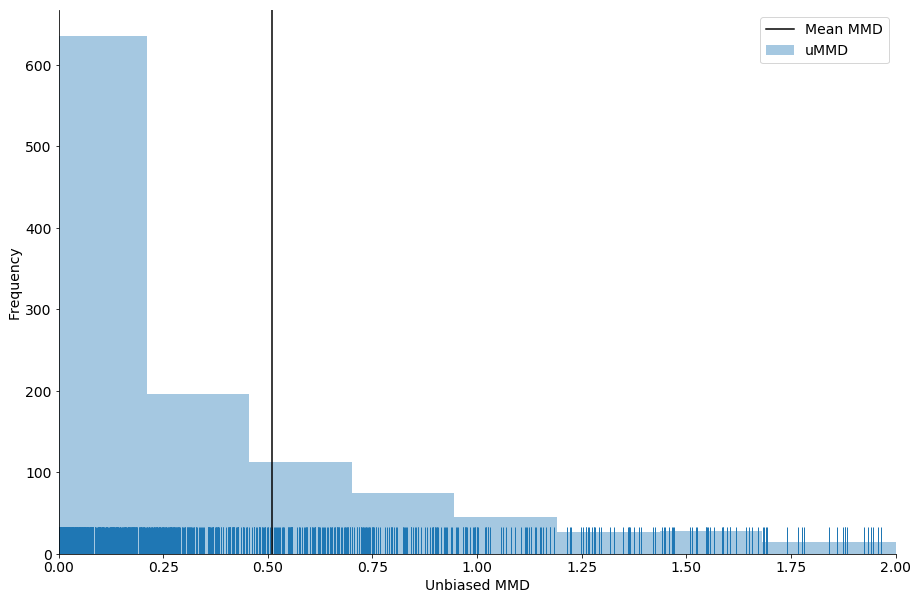

In [53]:
%%time
mmds = mmd_plot(model, b_reg, 500, X_test2, Y_test2)